In [66]:
import csv
import os

import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import neurokit2 as nk

from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter("ignore")

In [67]:
plt.rcParams['figure.figsize'] = [20, 5]

In [68]:
DATA_PATH = "../data"
SAMPLING_RATE = 300

In [69]:
X_test = pd.read_csv(f'{DATA_PATH}/X_test.csv')

In [70]:
data = pd.read_csv(f'{DATA_PATH}/X_train.csv')
labels = pd.read_csv(f'{DATA_PATH}/y_train.csv', index_col='id')

In [71]:
len(data)

5117

In [75]:
from tqdm import tqdm

def get_feature_mean_std(points, signal):
    vals = []
    for i in [p for p in points if p is not np.nan]:
        vals.append(signal[i])
    return np.mean(vals), np.std(vals)

def generate_feature_vector(r_peaks, signal, waves_peak):
    feature = []
    r_peaks_mean, r_peaks_std = get_feature_mean_std(r_peaks, signal)
    feature.append(r_peaks_mean)
    feature.append(r_peaks_std)
    for key in waves_peak.keys():
        mean, std = get_feature_mean_std(waves_peak[key], signal)
        feature.append(mean)
        feature.append(std)
    return np.array(feature)

def generate_RPQST_features(data):
    feature_names = [
        'r_peaks_mean', 'r_peaks_std', 
        'p_peaks_mean', 'p_peaks_std', 'q_peaks_mean', 'q_peaks_std',
        's_peaks_mean', 's_peaks_std', 't_peaks_mean', 't_peaks_std',
        'p_onsets_mean', 'p_onsets_std', 't_offsets_mean', 't_offsets_std']
    feature_vecs = []
    indices = []
    for i in tqdm(range(len(data))):
        signal = data.loc[i].dropna().to_numpy(dtype='float32')
#         r_peaks = ecg.engzee_segmenter(signal, SAMPLING_RATE)['rpeaks']
        feature_vector = None

        try:
            signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
            rpeaks = info["ECG_R_Peaks"]
            cleaned_signal = signals["ECG_Clean"]

            _, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

            feature_vector = generate_feature_vector(rpeaks, cleaned_signal, waves_peak)
            
        except:
            pass
        
        if feature_vector is None:
            feature_vector = [np.nan]*len(feature_names)
        feature_vecs.append(feature_vector)
        indices.append(i)
        
    return feature_names, np.array(feature_vecs), indices


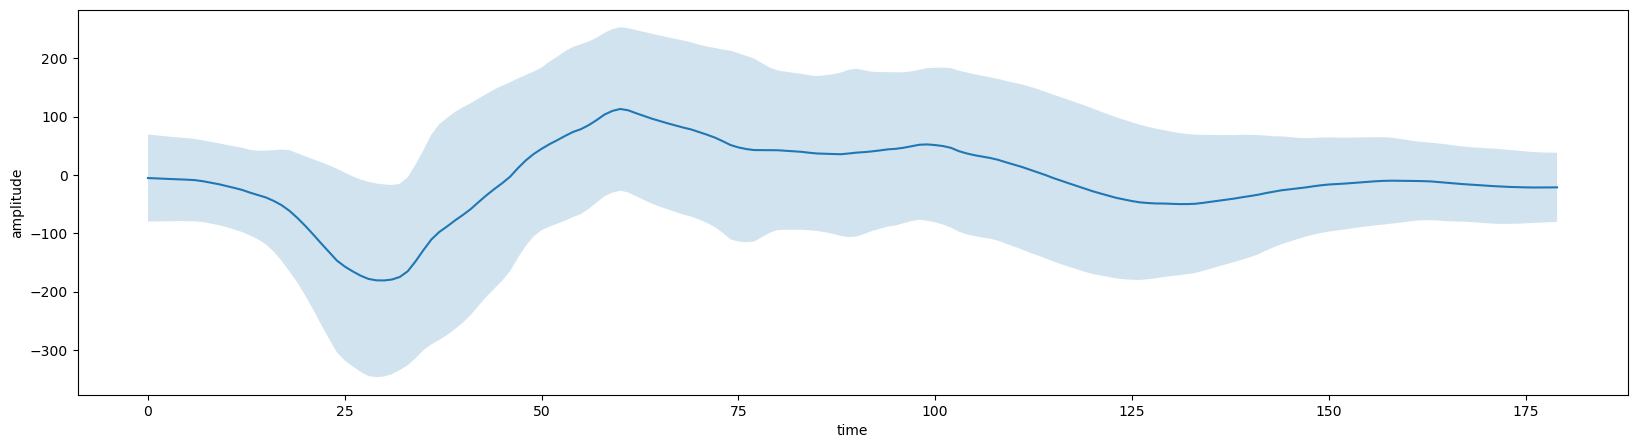

In [55]:
signal = data.loc[434].dropna().to_numpy(dtype='float32')
r_peaks = ecg.engzee_segmenter(signal, SAMPLING_RATE)['rpeaks']
beats = ecg.extract_heartbeats(signal, r_peaks, SAMPLING_RATE)['templates']
templates_mean = beats.mean(axis=0)
templates_std = beats.std(axis=0)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(templates_mean)
plt.fill_between(range(len(templates_mean)), templates_mean-templates_std, templates_mean+templates_std, alpha=0.2)
plt.show()

In [61]:
signal = data.loc[434].dropna().to_numpy(dtype='float32')
# r_peaks = ecg.engzee_segmenter(signal, SAMPLING_RATE)['rpeaks']
signals, info = nk.ecg_process(signal, sampling_rate=SAMPLING_RATE)
rpeaks = info["ECG_R_Peaks"]
cleaned_signal = signals["ECG_Clean"]
# print(rpeaks)
# print(len(cleaned_signal))
_, waves_peak = nk.ecg_delineate(cleaned_signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak", show=True)
len(rpeaks)
# feature_vector = generate_feature_vector(rpeaks, cleaned_signal, waves_peak)
# feature_vector

KeyError: '[8301] not in index'

In [64]:
%%time
features = generate_RPQST_features(data[434:435])
features

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]

CPU times: user 94.1 ms, sys: 79.5 ms, total: 174 ms
Wall time: 219 ms


(['r_peaks_mean',
  'r_peaks_std',
  'p_peaks_mean',
  'p_peaks_std',
  'q_peaks_mean',
  'q_peaks_std',
  's_peaks_mean',
  's_peaks_std',
  't_peaks_mean',
  't_peaks_std',
  'p_onsets_mean',
  'p_onsets_std',
  't_offsets_mean',
  't_offsets_std'],
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan]]),
 [0])

# Train

In [76]:
%%time
feature_names, features, indices = generate_RPQST_features(data)

100%|███████████████████████████████████████| 5117/5117 [17:54<00:00,  4.76it/s]

CPU times: user 17min 32s, sys: 13.9 s, total: 17min 46s
Wall time: 17min 54s


In [77]:
df = pd.DataFrame(data=features, columns=feature_names)
new_data = df.to_numpy()
# df.to_csv("X_train_rpqst_mean_std.csv", index=False)
with open("X_train.csv", "w") as f:
    f.write("id,"+",".join(feature_names) + "\n")
    for i, d in zip(indices, new_data):
        f.write(f"{str(i)},"+",".join([str(x) for x in d])+"\n")

with open("preserved.txt", "w") as f:
    for i in indices:
        f.write(str(i)+"\n")
        
labels_np = labels.to_numpy().reshape(-1)
new_labels = labels_np[indices]
with open("y_train.csv", "w") as f:
    f.write("id,y\n")
    for i in indices:
        f.write(str(i)+","+str(labels_np[i])+"\n")

# Test

In [78]:
%%time
feature_names, features, indices = generate_RPQST_features(X_test)

100%|███████████████████████████████████████| 3411/3411 [12:20<00:00,  4.61it/s]

CPU times: user 11min 52s, sys: 12.9 s, total: 12min 5s
Wall time: 12min 20s


In [80]:
df = pd.DataFrame(data=features, columns=feature_names)
new_data = df.to_numpy()
# df.to_csv("X_train_rpqst_mean_std.csv", index=False)
with open("X_test.csv", "w") as f:
    f.write("id,"+",".join(feature_names) + "\n")
    for i, d in zip(indices, new_data):
        f.write(f"{str(i)},"+",".join([str(x) for x in d])+"\n")

In [ ]:
# signal = np.array([x for x in data_np[0] if not np.isnan(x)])
signal = data.loc[2324].dropna().to_numpy(dtype='float32')
# out = ecg.ecg(signal=signal, sampling_rate=300., show=False)
# r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
# ext = ecg.extract_heartbeats(signal,rpeaks)
r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

In [495]:
try:
    signals, info = nk.ecg_process(signal, sampling_rate=300)
except:
    print("skip this point")

skip this point


In [144]:
rpeaks = info["ECG_R_Peaks"]
rpeaks

array([  103,   200,   449,   696,   949,  1205,  1460,  1711,  1967,
        2221,  2472,  2724,  2977,  3230,  3477,  3727,  3982,  4232,
        4479,  4728,  4972,  5215,  5454,  5693,  5930,  6163,  6400,
        6636,  6873,  7106,  7333,  7561,  7795,  8036,  8278,  8520,
        8768,  9015,  9266,  9515,  9763, 10014, 10262, 10510, 10756,
       11007, 11257, 11508, 11756, 12006, 12256, 12506, 12758, 13011,
       13258, 13505, 13755, 14007, 14260, 14510, 14761, 15013, 15264,
       15513, 15763, 16012, 16257])

In [145]:
cleaned_ecg = signals["ECG_Clean"]
len(cleaned_ecg)

16323

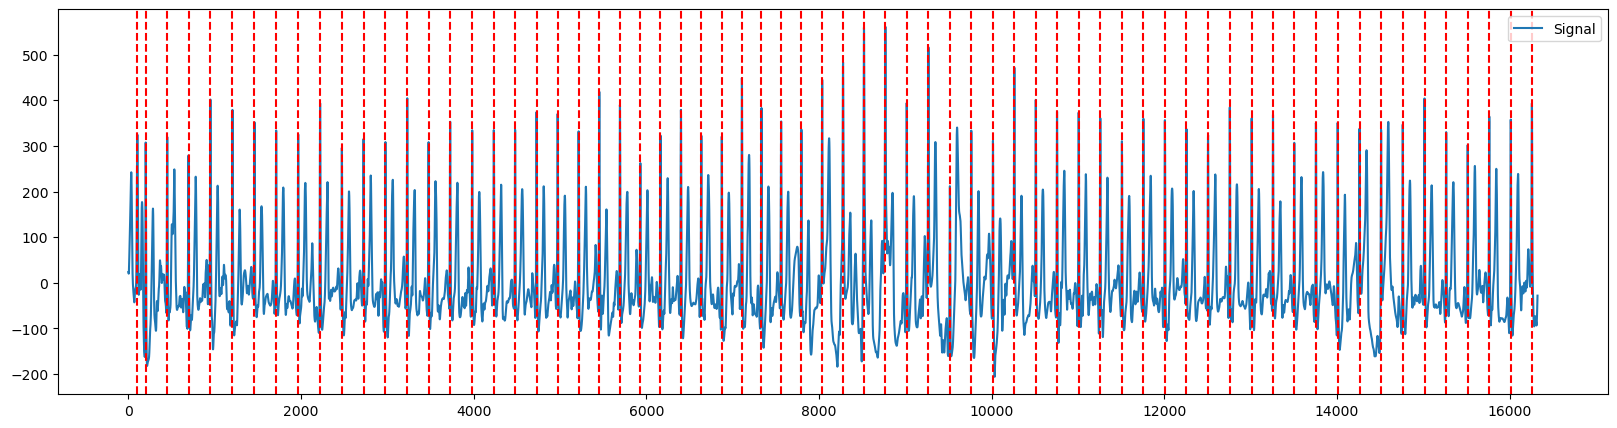

In [146]:
plot = nk.events_plot(rpeaks, cleaned_ecg)

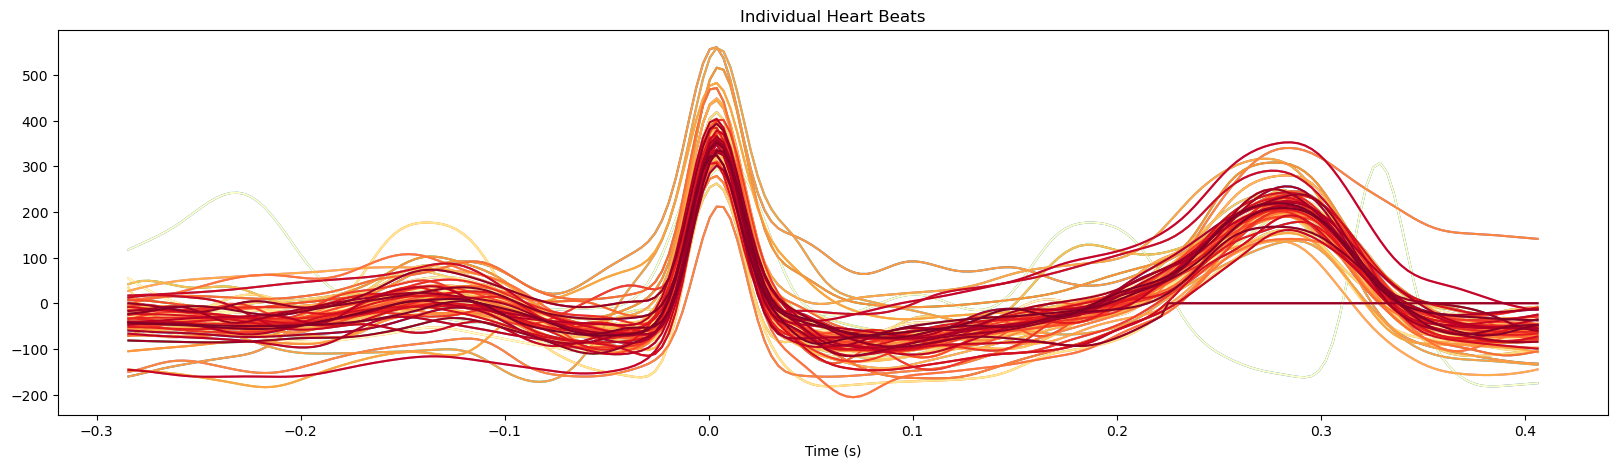

In [147]:
epochs = nk.ecg_segment(cleaned_ecg, rpeaks=None, sampling_rate=300, show=True)

In [148]:
_, waves_peak = nk.ecg_delineate(signal, rpeaks, sampling_rate=300, method="peak")

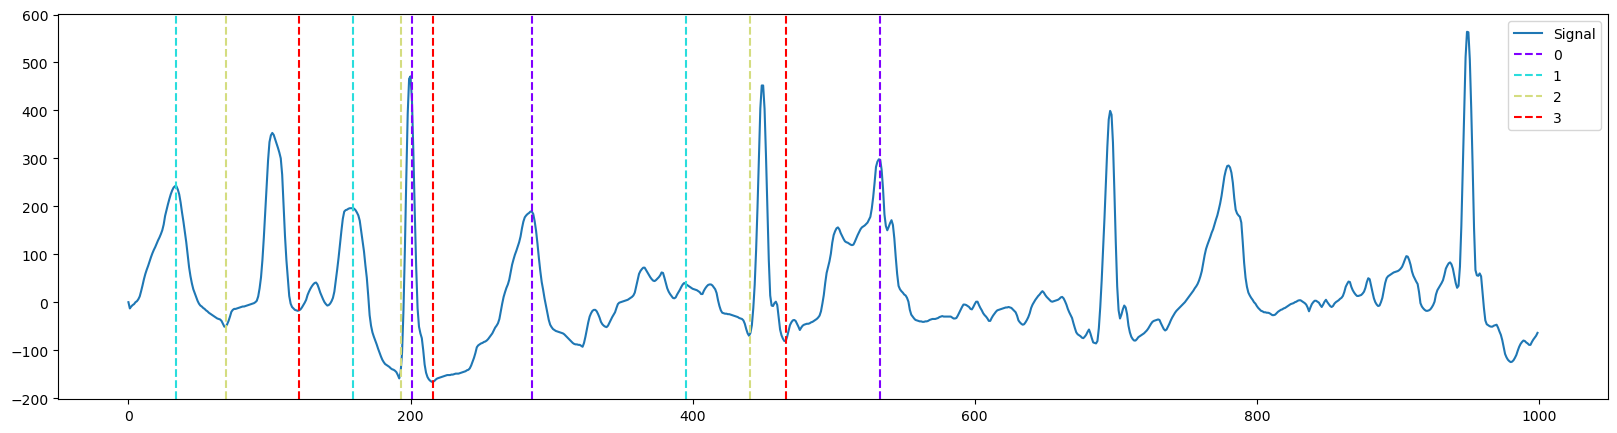

In [149]:
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3], 
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], signal[:1000])

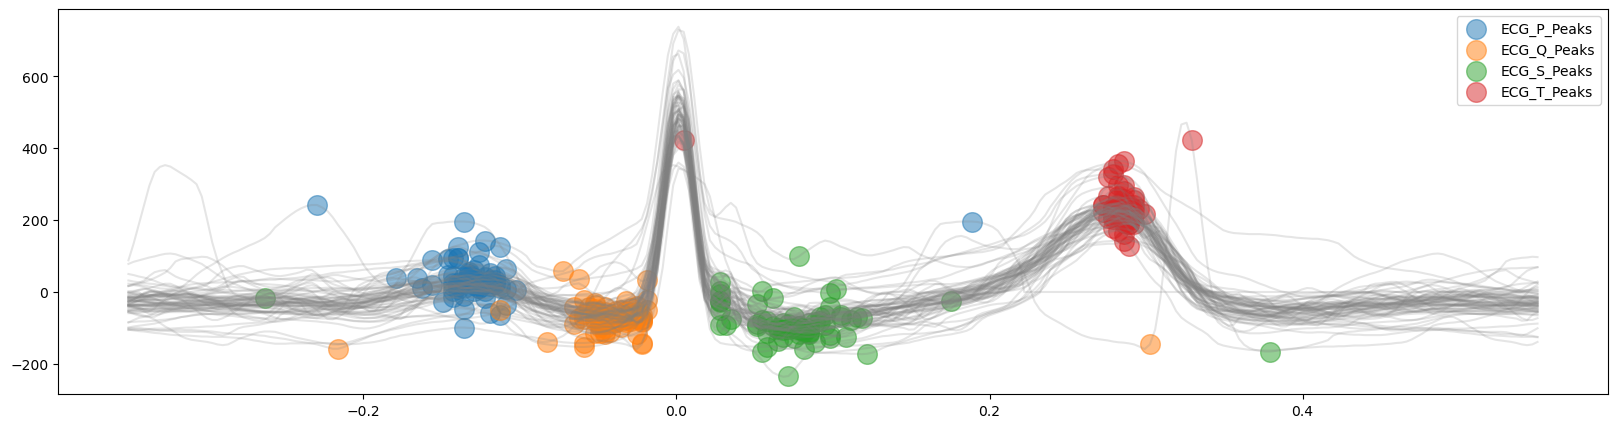

In [150]:
signals, waves_peak = nk.ecg_delineate(signal, 
                                 rpeaks, 
                                 sampling_rate=300, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

In [160]:
p_peaks = signals['ECG_P_Peaks'].to_numpy()
q_peaks = signals['ECG_Q_Peaks'].to_numpy()
s_peaks = signals['ECG_S_Peaks'].to_numpy()
t_peaks = signals['ECG_T_Peaks'].to_numpy()
p_onsets = signals['ECG_P_Onsets'].to_numpy()
t_offsets = signals['ECG_T_Offsets'].to_numpy()

In [192]:
def impute_mean(data):
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    data_imputed = imp_mean.fit_transform(np.array(data).reshape((-1,1))).reshape((-1))
    return data_imputed

In [243]:
def get_feature_mean_std(points, signal):
    vals = []
    for i in [p for p in points if p is not np.nan]:
        vals.append(signal[i])
    return np.mean(vals), np.std(vals)

In [252]:
get_feature_mean_std(r_peaks, cleaned_ecg)

(361.2806640383952, 60.9068128600321)

In [244]:
get_feature_mean_std(waves_peak['ECG_T_Peaks'], cleaned_ecg)

(214.4094569012933, 42.838128533294565)

In [245]:
get_feature_mean_std(waves_peak['ECG_P_Peaks'], cleaned_ecg)

(22.444980261804446, 53.79526275630589)

In [246]:
get_feature_mean_std(waves_peak['ECG_S_Peaks'], cleaned_ecg)

(-84.32665312829832, 48.86418422206587)

In [247]:
get_feature_mean_std(waves_peak['ECG_T_Peaks'], cleaned_ecg)

(214.4094569012933, 42.838128533294565)

In [250]:
get_feature_mean_std(waves_peak['ECG_P_Onsets'], cleaned_ecg)

(-29.407419713639218, 45.350194830442526)

In [251]:
get_feature_mean_std(waves_peak['ECG_T_Offsets'], cleaned_ecg)

(-29.786982606123004, 48.24924517467662)

In [452]:
np.std([284.9854130260645, 635.5094529318442, 435.5554811108797, 444.4526480042668, 391.8675530481892, 481.6014596208168, 441.63521279404046, 509.5505077534162, 494.7561279018736, 506.5633614883658, 389.53552598758574, 445.3539019845547, 442.7080262836871, 411.6822369047932, 457.33289222568703, 437.3807691180346, 421.75324077175213, 383.6092830526928, 485.00416060246584, 462.6167775660956, 558.8853790941919, 505.1716385952162, 395.5872007901071, 452.1905815316741, 420.9473258839749, 390.12535236465874, 395.6831604183148, 486.0436771881095, 452.50720614737065, 448.7124961401248, 551.0242906446193])

63.163920232278656

In [ ]:
signal = data.loc[2324].dropna().to_numpy(dtype='float32')
signals, info = nk.ecg_process(signal, sampling_rate=300)
signals

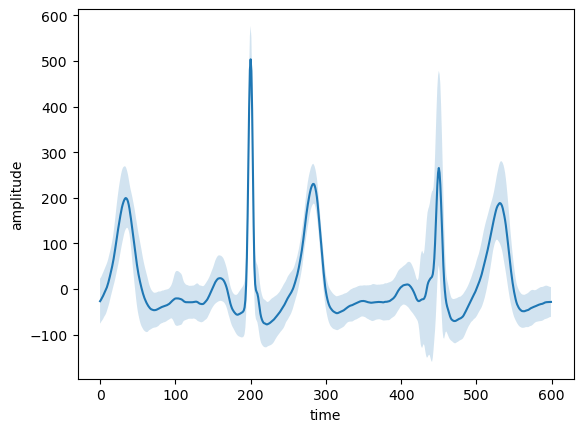

In [18]:
templates = ext[0]
templates_mean = templates.mean(axis=0)
templates_std = templates.std(axis=0)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(templates_mean)
plt.fill_between(range(len(templates_mean)), templates_mean-templates_std, templates_mean+templates_std, alpha=0.2)
plt.show()